# 📈 CHANGE POINT DETECTION

**Mục tiêu:** Phát hiện điểm gãy cấu trúc (Structural Break) trong dữ liệu điểm thi, tập trung vào năm 2025.

In [1]:
# --- CELL 1: SETUP HỆ THỐNG & IMPORT ---
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cấu hình đường dẫn để Python nhìn thấy thư mục 'Module' (nằm ở Project Root)
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 2. Cấu hình để Python nhìn thấy file 'ChangePoint.py' (nằm cùng thư mục Notebook)
if current_dir not in sys.path:
    sys.path.append(current_dir)

print(f"Project Root: {project_root}")

# --- IMPORT MODULES ---
from Module.Load_Data import CleanDataLoader

# Import class chuẩn bị dữ liệu (Của Bạn)
from ChangePoint import ChangePointPreparer

# Import class thuật toán (Của Nhóm Trưởng)
try:
    from Module.ChangePointDetector import ChangePointDetector
    print("✅ Đã import thành công: ChangePointDetector")
except ImportError:
    print("⚠️ Cảnh báo: Không tìm thấy 'ChangePointDetector' trong folder Module. Hãy kiểm tra lại file của nhóm trưởng.")

Project Root: c:\Users\ACER\PythonProject\PythonProject
✅ Đã import thành công: ChangePointDetector


## 1. Chuẩn bị dữ liệu (Data Preparation)

In [2]:
# --- CELL 2: LẤY DỮ LIỆU TỪ CLEAN LOADER ---

# 1. Khởi tạo
clean_loader = CleanDataLoader(project_root=project_root)
preparer = ChangePointPreparer(clean_loader)

# 2. Chọn đối tượng phân tích
# Môn học quan trọng
subjects_list = ["Toan", "NguVan", "NgoaiNgu", "VatLi", "LichSu"]
# Khối thi quan trọng
blocks_list = ["A00", "A01", "B00", "C00", "D01"]
# Tỉnh thành lớn (Dùng tên không dấu viết liền theo quy ước)
provinces_list = ["HaNoi", "HoChiMinh", "NamDinh", "NgheAn"]

# 3. Lấy chuỗi thời gian (Time Series)
print("⏳ Đang tải dữ liệu...")
df_subjects = preparer.get_subject_series(subjects_list, metric="mean")
df_blocks = preparer.get_block_series(blocks_list, metric="mean")
df_provinces = preparer.get_province_series(provinces_list, metric="mean")

print("\n--- Sample Data (Môn học) ---")
display(df_subjects.head())

⏳ Đang tải dữ liệu...

--- Sample Data (Môn học) ---


,year,series_id,value
0,2023,Toan,6.250557
1,2024,Toan,6.447309
2,2025,Toan,4.799712


## 2. Phát hiện điểm gãy (Change Point Detection)
Sử dụng các thuật toán: **PELT** (Ruptures) và **CUSUM**.

In [3]:
pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [4]:
# --- CELL 3: CHẠY THUẬT TOÁN  ---

if 'ChangePointDetector' in globals():
    # 1. Khởi tạo bộ phát hiện (Giả thuyết điểm gãy là năm 2025, sai số 1 năm)
    # Chúng ta gộp cả 3 loại dữ liệu vào để chạy một thể cho hoành tráng
    full_data = pd.concat([df_subjects, df_blocks, df_provinces], ignore_index=True)
    
    detector = ChangePointDetector(full_data, target_year=2025, tolerance=1)

    # 2. Chạy PELT (Tinh chỉnh penalty=1 vì chuỗi ngắn 3 năm)
    print("\n▶️ Đang chạy thuật toán PELT...")
    df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
    display(df_pelt.head())

    # 3. Chạy CUSUM
    print("\n▶️ Đang chạy thuật toán CUSUM...")
    df_cusum = detector.detect_cusum()
    display(df_cusum.head())

    # 4. Tổng hợp kết quả (Những series nào thực sự gãy ở 2025?)
    print("\n🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---")
    all_results = detector.analyze_all()
    hits = all_results[all_results['hit_target'] == True]
    display(hits)
else:
    print("❌ Không thể chạy thuật toán vì thiếu Module ChangePointDetector.")


▶️ Đang chạy thuật toán PELT...


,series_id,algorithm,detected_years,hit_target,hit_year
0,Toan,Ruptures_pelt_l2,[2025],True,2025
1,A00,Ruptures_pelt_l2,[2025],True,2025
2,A01,Ruptures_pelt_l2,[2025],True,2025
3,B00,Ruptures_pelt_l2,[2025],True,2025
4,C00,Ruptures_pelt_l2,[2025],True,2025



▶️ Đang chạy thuật toán CUSUM...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,CUSUM_Mean,[2025],True,2025,"[0.5689714158646144, 1.4057366370051718, 0.0]"
1,A00,CUSUM_Mean,[2025],True,2025,"[0.6104272905789431, 1.4099914022104518, 1.043..."
2,A01,CUSUM_Mean,[2025],True,2025,"[0.562634073520074, 1.4049638560434103, -9.992..."
3,B00,CUSUM_Mean,[2025],True,2025,"[0.7418642137567919, 1.4136344211849636, 6.661..."
4,C00,CUSUM_Mean,[2024],True,2024,"[-1.1088879966200527, 0.20567149173998867, 1.3..."



🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,Ruptures_pelt_l2,[2025],True,2025,NaN
1,A00,Ruptures_pelt_l2,[2025],True,2025,NaN
2,A01,Ruptures_pelt_l2,[2025],True,2025,NaN
3,B00,Ruptures_pelt_l2,[2025],True,2025,NaN
4,C00,Ruptures_pelt_l2,[2025],True,2025,NaN
5,D01,Ruptures_pelt_l2,[2025],True,2025,NaN
6,HaNoi,Ruptures_pelt_l2,[2025],True,2025,NaN
7,NgheAn,Ruptures_pelt_l2,[2025],True,2025,NaN
8,Toan,CUSUM_Mean,[2025],True,2025,"[0.5689714158646144, 1.4057366370051718, 0.0]"
9,A00,CUSUM_Mean,[2025],True,2025,"[0.6104272905789431, 1.4099914022104518, 1.043..."


## 3. Trực quan hóa (Visualization)
Vẽ biểu đồ minh họa sự thay đổi cấu trúc.

Đang vẽ biểu đồ nâng cao cho: Toan


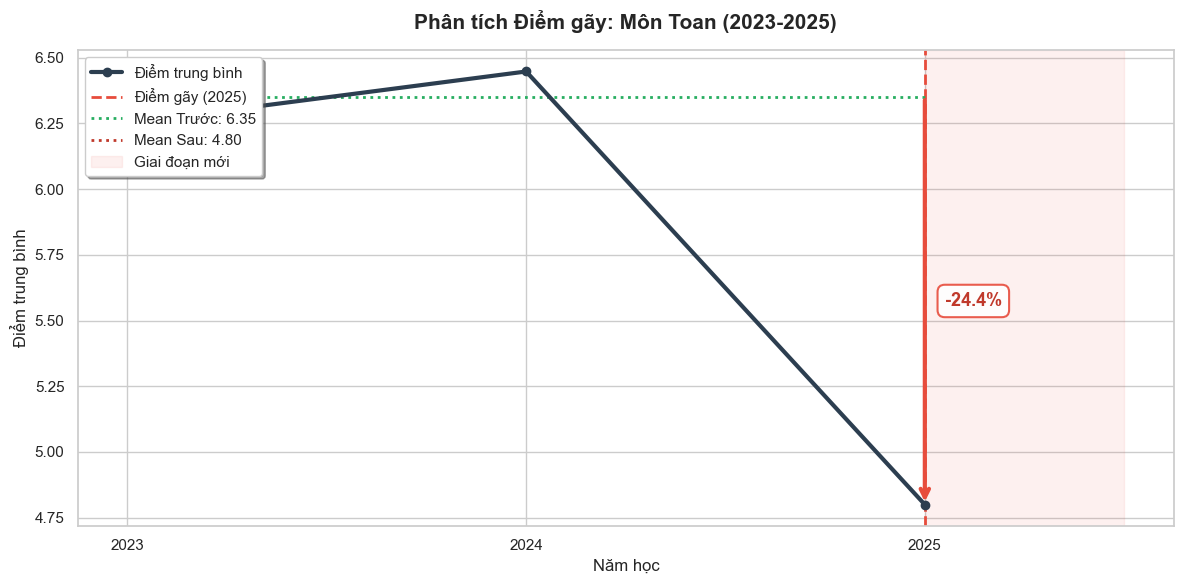

In [5]:
# --- CELL 4: VẼ BIỂU ĐỒ (PHIÊN BẢN GỠ LỖI) ---
# Giả sử detector đã chạy và có kết quả
if 'detector' in locals() and hasattr(detector, 'results'):
    # Lấy đại một kết quả có điểm gãy để vẽ demo
    # Ưu tiên lấy môn Toán hoặc Văn nếu có
    target_series = "Toan"
    row = detector.results[detector.results['series_id'] == target_series]
    
    if not row.empty and len(row.iloc[0]['detected_years']) > 0:
        years = row.iloc[0]['detected_years']
        print(f"Đang vẽ biểu đồ nâng cao cho: {target_series}")
        
        # GỌI HÀM MỚI TẠI ĐÂY
        detector.plot_enhanced(target_series, years)
    else:
        # Nếu Toán không gãy, lấy cái đầu tiên tìm được
        has_break = detector.results[detector.results['detected_years'].apply(len) > 0]
        if not has_break.empty:
            s_id = has_break.iloc[0]['series_id']
            yrs = has_break.iloc[0]['detected_years']
            detector.plot_enhanced(s_id, yrs)
        else:
            print("Chưa tìm thấy điểm gãy nào để vẽ.")
